In [23]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%run phasedecoder907.ipynb
from src.folder_handler import *
from src.cort_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import math
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from scipy import signal
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
with open('/mnt/c/oobootoo/rat-fes/data/pickles/3-lemons919__session.pkl', 'rb') as inp:
    lem919_session = pickle.load(inp)
lem919_rates = lem919_session.data['rates']
lem919_angles = lem919_session.data['angles']
lem919_coords = lem919_session.data['coords']

with open('/mnt/c/oobootoo/rat-fes/data/pickles/3-meepo919__session.pkl', 'rb') as inp:
    mep919_session = pickle.load(inp)
mep919_rates = mep919_session.data['rates']
mep919_angles = mep919_session.data['angles']
mep919_coords = mep919_session.data['coords']

In [25]:
mep919_angles[0].shape

(6124, 7)

In [26]:
lem919arctans, lem919phase_list, lem919H_sin, lem919H_cos, lem919r, lem919full_rates = phase_train(lem919_rates, lem919_angles)
lem919tsf = np.linspace(0, (lem919phase_list.shape[0]*50)/1000,lem919phase_list.shape[0])

mep919arctans, mep919phase_list, mep919H_sin, mep919H_cos, mep919r, mep919full_rates = phase_train(mep919_rates, mep919_angles)
mep919tsf = np.linspace(0, (mep919phase_list.shape[0]*50)/1000,mep919phase_list.shape[0])

(15150, 7)
(12108, 7)


In [27]:
# rates_by_phase, phase_tracker = rates_by_gait(mep919phase_list[:,3], mep919full_rates, 1, plotting=True)
# rates_by_gait(mep919phase_list[:,3], mep919full_rates, 3, 10, plotting=True)
# rates_by_gait_alt(mep919phase_list, mep919full_rates, 3, 10, plotting=True)

<bound method Figure.tight_layout of <Figure size 1200x1600 with 6 Axes>>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
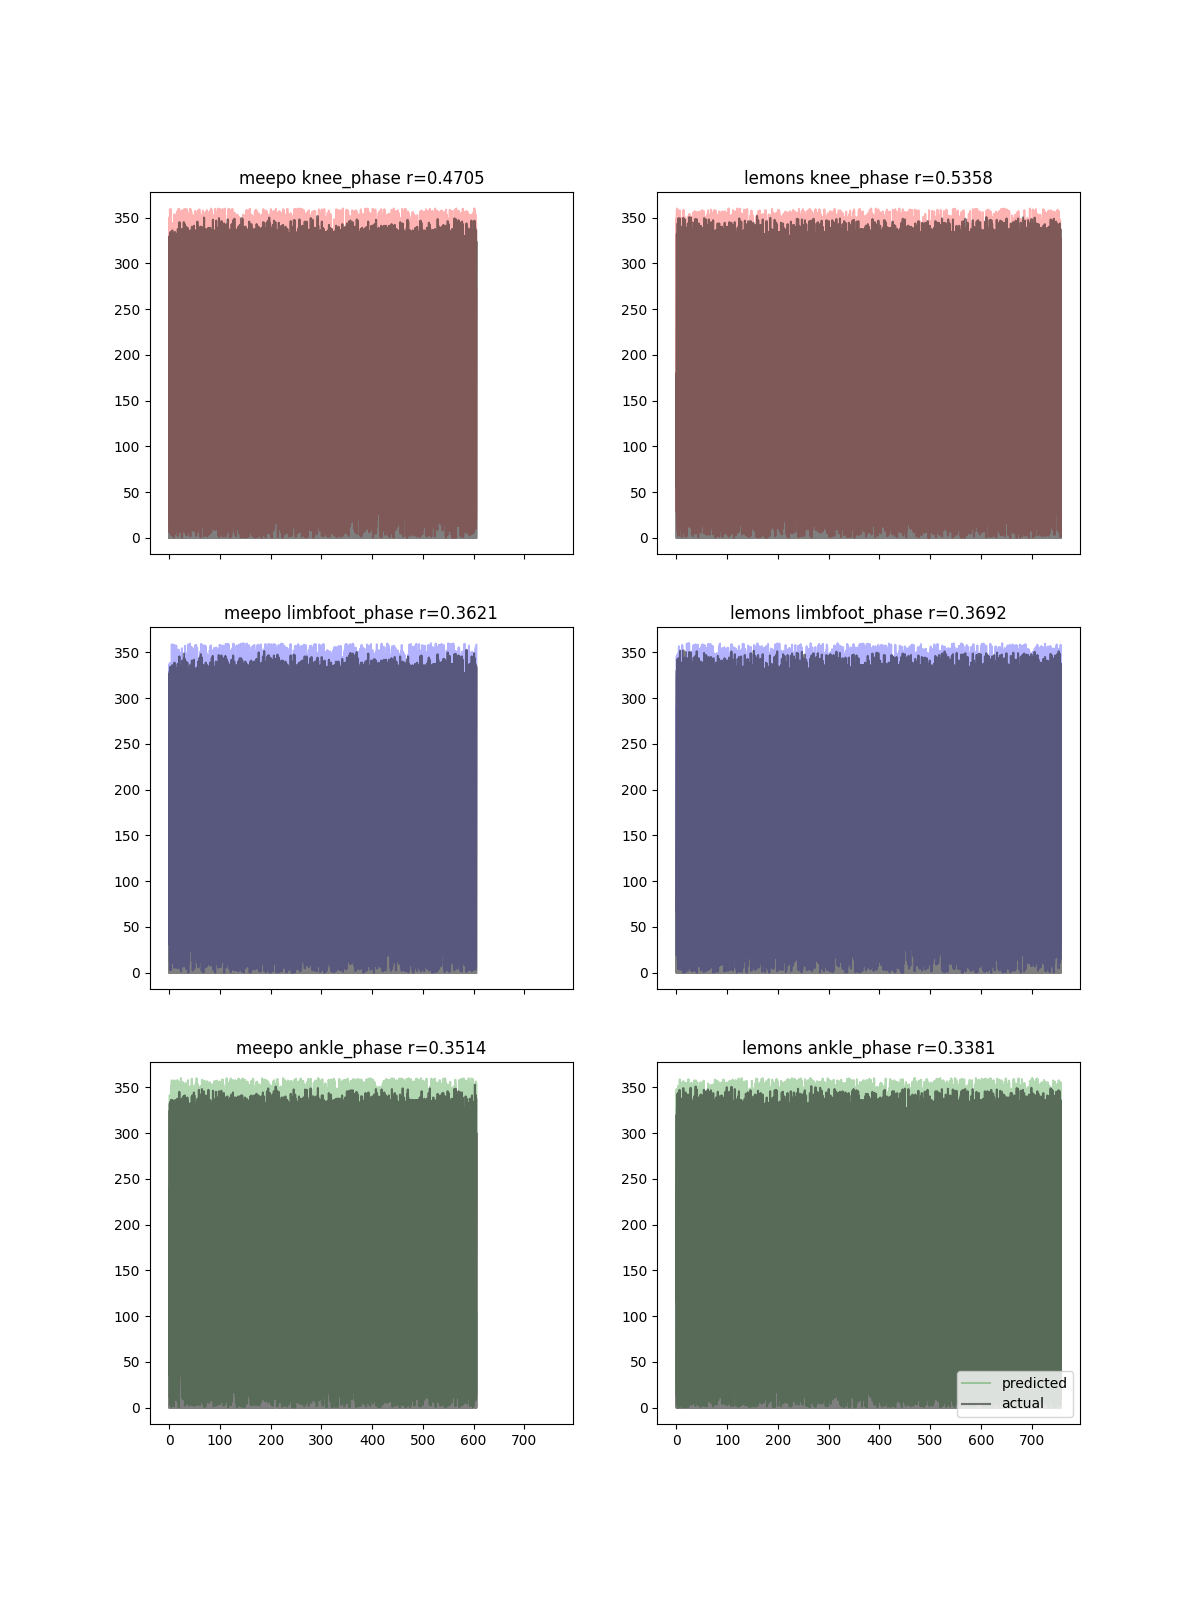

In [28]:
fig512, ax = plt.subplots(3,2, figsize=(12,16), sharex = True)
ax[0,0].set_title('meepo knee_phase r=' + f'{mep919r[1]:.{4}f}')
ax[0,0].plot(mep919tsf, mep919arctans[:,1], c='r', alpha=0.3, label = "predicted")
ax[0,0].plot(mep919tsf, mep919phase_list[:,1], c='k', alpha=0.5, label = "actual")
ax[0,1].set_title('lemons knee_phase r=' + "{0:.4f}".format(lem919r[1]))
ax[0,1].plot(lem919tsf, lem919arctans[:,1], c='r', alpha=0.3, label = "predicted")
ax[0,1].plot(lem919tsf, lem919phase_list[:,1], c='k', alpha=0.5, label = "actual")
ax[1,0].set_title('meepo limbfoot_phase r=' + f'{mep919r[3]:.{4}f}')
ax[1,0].plot(mep919tsf, mep919arctans[:,3], c='b', alpha=0.3, label = "predicted")
ax[1,0].plot(mep919tsf, mep919phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax[1,1].set_title('lemons limbfoot_phase r=' + "{0:.4f}".format(lem919r[3]))
ax[1,1].plot(lem919tsf, lem919arctans[:,3], c='b', alpha=0.3, label = "predicted")
ax[1,1].plot(lem919tsf, lem919phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax[2,0].set_title('meepo ankle_phase r=' + f'{mep919r[0]:.{4}f}')
ax[2,0].plot(mep919tsf, mep919arctans[:,0], c='g', alpha=0.3, label = "predicted")
ax[2,0].plot(mep919tsf, mep919phase_list[:,0], c='k', alpha=0.5, label = "actual")
ax[2,1].set_title('lemons ankle_phase r=' + "{0:.4f}".format(lem919r[0]))
ax[2,1].plot(lem919tsf, lem919arctans[:,0], c='g', alpha=0.3, label = "predicted")
ax[2,1].plot(lem919tsf, lem919phase_list[:,0], c='k', alpha=0.5, label = "actual")
ax[2,1].legend(loc="lower right")
fig512.tight_layout

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
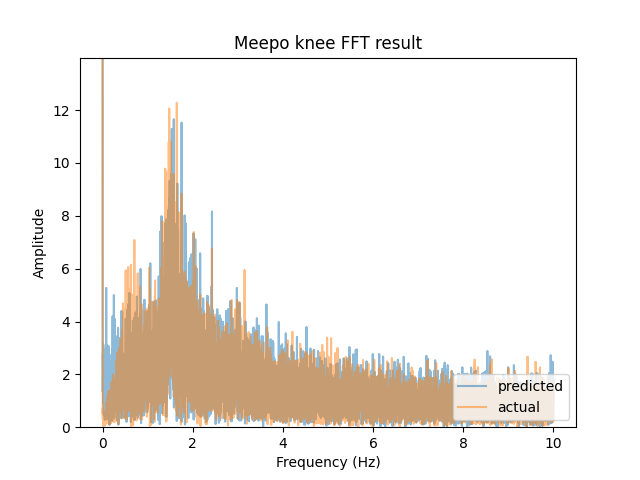

In [6]:
N = mep919tsf.shape[0]
# sample spacing
T = mep919tsf[1]-mep919tsf[0]
x = mep919tsf
y1 = mep919arctans[:,1]
y1f = fft(y1)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
y1fp = 2.0/N * np.abs(y1f[:N//2])
y2 = mep919phase_list[:,1]
y2f = fft(y2)
y2fp = 2.0/N * np.abs(y2f[:N//2])
fig, ax = plt.subplots()
ax.plot(xf, y1fp, alpha = 0.5, label='predicted')
ax.plot(xf, y2fp, alpha = 0.5, label='actual')
ax.set(ylabel='Amplitude',xlabel='Frequency (Hz)',title='Meepo knee FFT result')
ax.set_ylim([0, y1fp[np.argsort(y1fp, axis=0)[-2]] * 1.2]) 
ax.legend(loc='lower right')
plt.show()

In [7]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [8]:
mep919full_rates.shape


(12108, 320)

In [9]:
impulse_alignment(mep919H_cos, mep919phase_list, mep919full_rates, 3, 10)


NameError: name 'impulse_alignment' is not defined

In [10]:
def impulse_response_malleable(H_mat, AOI, full_phase_list, plotting = False):
    column_response = []
    for i in range(0,32):
            product_list = []
            for j in range(0,10):
                dummyarray = np.zeros((10,32))
                dummyarray[-1,i] = 1
                dummyarray = np.roll(dummyarray,-j,axis = 0)
                dummyarray = dummyarray.flatten()
                dummyarray = np.insert(dummyarray,0,1)
                dummyarray = dummyarray.reshape(321,1)
                dummyarray = dummyarray.T
                product = np.dot(dummyarray, H_mat)
                product_list.append(product[0])
            product_list = np.array(product_list)
            column_response.append(product_list)
    av_gait_bins = average_gait_bins(full_phase_list, AOI)
    padded_column_response = []
    if (av_gait_bins - 10) >= 1:
        n = av_gait_bins-10
        for i in range(len(column_response)):
            # padded_column = np.append(column_response[i][:,AOI], np.full((n,1), np.min(column_response[i][:,AOI])))
            padded_column = np.append(column_response[i][:,AOI], np.full((n,1), np.mean(column_response[i][:,AOI])))
            padded_column_response.append(padded_column)
        padded_column_response = np.array(padded_column_response)
    if plotting == True:
        fig1, ax1 = plt.subplots()
        x = np.arange(0,10,1)        
        for i in range(len(column_response)):
            ax1.plot(x, column_response[i][:,AOI])
        ax1.set_xticks(x)
    return padded_column_response

def rates_by_gait_malleable(full_phase_list, rates_array, AOI, resolution, plotting = False):
    phase_list = full_phase_list[:,AOI]
    bins = resolution * average_gait_bins(full_phase_list, AOI)
    step = 360/bins
    rate_storage = []
    for i in range(0, bins):
    # for i in range(0, 1):
        ceil = (i+1)*step
        floor = i*step
        rates_tmp = []
        for j in range(phase_list.shape[0]):   
            if floor <= phase_list[j] < ceil:
                rates_tmp.append(rates_array[i,-32:])
        if not rates_tmp:
            rates_tmp.append(np.zeros(32))
        rates_tmp = np.mean(rates_tmp, axis = 0)
        rate_storage.append(rates_tmp)
    rate_storage = np.array(rate_storage)
    return rate_storage

def average_gait_bins(full_phase_list, AOI):
    gait_lengths = []
    gait_indicies = np.where(full_phase_list[:,AOI]==0)[0]
    for i in range(1, gait_indicies.shape[0]):
        gait_length = gait_indicies[i]-gait_indicies[i-1]
        gait_lengths = np.append(gait_lengths, gait_length)
    av_gait_length = math.ceil(np.average(gait_lengths))
    return av_gait_length

# def impulse_alignment(H_mat, phase_list, rates_array, AOI, resolution = 1):
#     padded_channel_response = impulse_response_malleable(H_mat, AOI, phase_list, plotting=False)
#     rates_by_phase = rates_by_gait_malleable(phase_list, rates_array, AOI, resolution = 1, plotting = False)
#     fig=plt.figure()
#     ax=fig.add_subplot(111, label="1")
#     ax2=fig.add_subplot(111, label="2", frame_on=False)
#     colors = ['aliceblue', 'coral', 'burlywood','goldenrod','palegreen','paleturquoise','slategray','plum','cadetblue','crimson','chartreuse','gold',
# 'blueviolet','darkgreen','fuchsia','orchid', 'forestgreen','royalblue']
#     impulse_bins = padded_channel_response[0].shape[0]
#     x_values1=phase_tracker
#     x_values2= np.arange(0,impulse_bins,1) 
#     for i in range(rates_by_phase.shape[1]):
#     # for i in range(0,1):
#         color_index = i % len(colors)
#         peak_percent = phase_tracker[np.argmax(rates_by_phase[:,i])]/
#         bin_roll = int(impulse_bins*peak_percent)
#         padded_channel_response[i] = np.roll(padded_channel_response[i],bin_roll-1)
#         ax.plot(x_values1, rates_by_phase[:,i],alpha=0.1,color=colors[color_index])
#         ax2.plot(x_values2, padded_channel_response[i],color=colors[color_index])
#     ax.set_xlabel("Phase Angle", color="C0")
#     ax.set_ylabel("Spike Rate", color="C0")
#     ax.tick_params(axis='x', colors="C0")
#     ax.tick_params(axis='y', colors="C0")
#     ax2.xaxis.tick_top()
#     ax2.yaxis.tick_right()
#     ax2.set_ylabel("Impluse Response", color="C1")       
#     ax2.xaxis.set_label_position('top') 
#     ax2.yaxis.set_label_position('right') 
#     ax2.tick_params(axis='x', colors="white")
#     ax2.tick_params(axis='y', colors="C1")
#     plt.show()

In [11]:
# full_phase_list = mep919phase_list
# rates_array = mep919full_rates
# AOI = 3
# H_mat = mep919H_cos
# resolution = 2

# bins = resolution * average_gait_bins(full_phase_list, AOI)
# padded_channel_response = impulse_response_malleable(H_mat, AOI, full_phase_list, plotting=False)
# rates_by_phase = rates_by_gait_malleable(full_phase_list, rates_array, AOI, resolution, plotting = False)
# fig=plt.figure()
# colors = ['coral', 'burlywood','goldenrod','palegreen','paleturquoise','slategray','plum','cadetblue','crimson','chartreuse','gold',
# 'blueviolet','darkgreen','fuchsia','orchid', 'forestgreen','royalblue']
# impulse_bins = padded_channel_response[0].shape[0]
# x_values2= np.arange(0,impulse_bins,1) 
# x_values1= np.arange(0,(x_values2[-1]+1)*resolution,1)*350/bins
# x_values3 = np.arange(0,360,1)
# z_range = np.arange(0,32,1)
# # 
# channel_range = np.arange(0,32,1)
# for i in channel_range:
#     color_index = i % len(colors)
#     peak_incidence = math.floor(np.argmax(rates_by_phase[:,i])/resolution)
#     padded_channel_response[i] = np.roll(padded_channel_response[i],peak_incidence)
#     ax.bar3d(x_values1, rates_by_phase[:,i], z_range[i], dx, dy, dz, color=colors[color_index])#, align = 'edge', alpha = 0.3)
#     ax2.plot(x_values2, padded_channel_response[i], z_range[i], linestyle='--',color=colors[color_index])
# ax.set_xlabel("Phase Angle", color="C0")
# ax.set_ylabel("Spike Rate", color="C0")
# ax.tick_params(axis='x', colors="C0")
# ax.tick_params(axis='y', colors="C0")
# ax2.xaxis.tick_top()
# ax2.yaxis.tick_right()
# ax2.set_ylabel("Impluse Response", color="C1")       
# ax2.xaxis.set_label_position('top') 
# ax2.yaxis.set_label_position('right') 
# ax2.tick_params(axis='x', colors="white")
# ax2.tick_params(axis='y', colors="C1")
# ax.set_xlim([0,360])
# ax2.set_xlim([x_values2[0],x_values2[-1]])


# colors = ['coral', 'burlywood','goldenrod','palegreen','paleturquoise','slategray','plum','cadetblue','crimson','chartreuse','gold',
# 'blueviolet','darkgreen','fuchsia','orchid', 'forestgreen','royalblue']
# impulse_bins = padded_channel_response[0].shape[0]
# x_values2= np.arange(0,impulse_bins,1) 
# x_values1= np.arange(0,(x_values2[-1]+1)*resolution,1)*350/bins
# x_values3 = np.arange(0,360,1)
# fig = plt.figure()
# ax=fig.add_subplot(111, label="1",projection='3d')
# ax2=fig.add_subplot(111, label="2", projection='3d', frame_on=False)
# # channel_range = np.arange(0,32,1)
# channel_range = [0, 5]
# for i in channel_range:
#     color_index = i % len(colors)
#     peak_incidence = math.floor(np.argmax(rates_by_phase[:,i])/resolution)
#     padded_channel_response[i] = np.roll(padded_channel_response[i],peak_incidence)
# #     ax.bar3d(x_values1, rates_by_phase[:,i], z_range[i], dx, dy, dz, color=colors[color_index])#, align = 'edge', alpha = 0.3)
#     # ax2.plot(x_values2, padded_channel_response[i], z_range[i], linestyle='--',color=colors[color_index])
#     # You can provide either a single color or an array with the same length as
#     # xs and ys. To demonstrate this, we color the first bar of each set cyan.
#     # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
#     ax.bar(x_values1, rates_by_phase[:,i], zs=i, zdir='y', align = 'edge', color=colors[color_index], alpha=0.8)
# ax.set_xlabel("Phase Angle", color="C0")
# ax.set_ylabel("Spike Rate", color="C0")
# # ax.tick_params(axis='x', colors="C0")
# # ax.tick_params(axis='y', colors="C0")
# # ax2.xaxis.tick_top()
# # ax2.yaxis.tick_right()
# # ax2.set_ylabel("Impluse Response", color="C1")       
# # ax2.xaxis.set_label_position('top') 
# # ax2.yaxis.set_label_position('right') 
# # ax2.tick_params(axis='x', colors="white")
# # ax2.tick_params(axis='y', colors="C1")
# ax.set_xlim([0,360])
# # ax2.set_xlim([x_values2[0],x_values2[-1]])
# # ax.set_xlabel('X')
# # ax.set_ylabel('Y')
# # ax.set_zlabel('Z')

# # On the y axis let's only label the discrete values that we have data for.
# ax.set_yticks(yticks)

# plt.show()

In [36]:
def impulse_response_malleable(H_mat, AOI, full_phase_list, plotting = False):
    column_response = []
    for i in range(0,32):
            product_list = []
            for j in range(0,10):
                dummyarray = np.zeros((10,32))
                dummyarray[-1,i] = 1
                dummyarray = np.roll(dummyarray,-j,axis = 0)
                dummyarray = dummyarray.flatten()
                dummyarray = np.insert(dummyarray,0,1)
                dummyarray = dummyarray.reshape(321,1)
                dummyarray = dummyarray.T
                product = np.dot(dummyarray, H_mat)
                product_list.append(product[0])
            product_list = np.array(product_list)
            column_response.append(product_list)
    av_gait_bins = average_gait_bins(full_phase_list, AOI)
    padded_column_response = []
    if (av_gait_bins - 10) >= 1:
        n = av_gait_bins-10
        for i in range(len(column_response)):
            # padded_column = np.append(column_response[i][:,AOI], np.full((n,1), np.min(column_response[i][:,AOI])))
            padded_column = np.append(column_response[i][:,AOI], np.full((n,1), np.mean(column_response[i][:,AOI])))
            padded_column_response.append(padded_column)
        padded_column_response = np.array(padded_column_response)
    if plotting == True:
        fig1, ax1 = plt.subplots()
        x = np.arange(0,10,1)        
        for i in range(len(column_response)):
            ax1.plot(x, column_response[i][:,AOI])
        ax1.set_xticks(x)
    return padded_column_response

def rates_by_gait_malleable(full_phase_list, rates_array, AOI, resolution, plotting = False):
    phase_list = full_phase_list[:,AOI]
    bins = resolution * average_gait_bins(full_phase_list, AOI)
    step = 360/bins
    rate_storage = []
    for i in range(0, bins):
    # for i in range(0, 1):
        ceil = (i+1)*step
        floor = i*step
        rates_tmp = []
        for j in range(phase_list.shape[0]):   
            if floor <= phase_list[j] < ceil:
                rates_tmp.append(rates_array[i,-32:])
        if not rates_tmp:
            rates_tmp.append(np.zeros(32))
        rates_tmp = np.mean(rates_tmp, axis = 0)
        rate_storage.append(rates_tmp)
    rate_storage = np.array(rate_storage)
    return rate_storage

def average_gait_bins(full_phase_list, AOI):
    gait_lengths = []
    gait_indicies = np.where(full_phase_list[:,AOI]==0)[0]
    for i in range(1, gait_indicies.shape[0]):
        gait_length = gait_indicies[i]-gait_indicies[i-1]
        gait_lengths = np.append(gait_lengths, gait_length)
    av_gait_length = math.ceil(np.average(gait_lengths))
    return av_gait_length

def ratexresponsemap(full_phase_list, rates_array, AOI, H_mat, resolution, channel_range = np.arange(0,32,1), view = '2D'):
    if view == '2D':
        bins = resolution * average_gait_bins(full_phase_list, AOI)
        padded_channel_response = impulse_response_malleable(H_mat, AOI, full_phase_list, plotting=False)
        rates_by_phase = rates_by_gait_malleable(full_phase_list, rates_array, AOI, resolution, plotting = False)
        fig0=plt.figure()
        ax=fig0.add_subplot(111, label="1")
        ax2=fig0.add_subplot(111, label="2", frame_on=False)
        colors = ['coral', 'burlywood','goldenrod','palegreen','paleturquoise','slategray','plum','cadetblue','crimson','chartreuse','gold',
        'blueviolet','darkgreen','fuchsia','orchid', 'forestgreen','royalblue']
        impulse_bins = padded_channel_response[0].shape[0]
        x_values2= np.arange(0,impulse_bins,1) 
        x_values1= np.arange(0,(x_values2[-1]+1)*resolution,1)*350/bins
        x_values3 = np.arange(0,360,1)
        for i in channel_range:
            color_index = i % len(colors)
            peak_incidence = math.floor(np.argmax(rates_by_phase[:,i])/resolution)
            rolled_channel = np.roll(padded_channel_response[i],peak_incidence)
            ax.bar(x_values1, rates_by_phase[:,i],color=colors[color_index], align = 'edge', width = x_values1[1]-x_values1[0], alpha = 0.3)
            ax2.plot(x_values2, rolled_channel, linestyle='--',color=colors[color_index])
        ax.set_xlabel("Phase Angle", color="C0")
        ax.set_ylabel("Spike Rate", color="C0")
        ax.tick_params(axis='x', colors="C0")
        ax.tick_params(axis='y', colors="C0")
        ax2.xaxis.tick_top()
        ax2.yaxis.tick_right()
        ax2.set_ylabel("Impluse Response", color="C1")       
        ax2.xaxis.set_label_position('top') 
        ax2.yaxis.set_label_position('right') 
        ax2.tick_params(axis='x', colors="white")
        ax2.tick_params(axis='y', colors="C1")
        ax.set_xlim([0,360])
        plt.show()
    if view == '3D':
        bins = resolution * average_gait_bins(full_phase_list, AOI)
        padded_channel_response = impulse_response_malleable(H_mat, AOI, full_phase_list, plotting=False)
        rates_by_phase = rates_by_gait_malleable(full_phase_list, rates_array, AOI, resolution, plotting = False)
        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
        impulse_bins = padded_channel_response[0].shape[0]
        x_values2= np.arange(0,impulse_bins,1) 
        x_values1= np.arange(0,(x_values2[-1]+1)*resolution,1)*350/bins
        colors = ['coral', 'burlywood','goldenrod','palegreen','paleturquoise','slategray','plum','cadetblue','crimson','chartreuse','gold',
        'blueviolet','darkgreen','fuchsia','orchid', 'forestgreen','royalblue']
        if type(channel_range) == list:
            for i in channel_range:
                color_index = i % len(colors)
                peak_incidence = math.floor(np.argmax(rates_by_phase[:,i])/resolution)
                rolled_channel = np.roll(padded_channel_response[i],peak_incidence)
                ax2.plot(x_values2,rolled_channel, zs=channel_range.index(i), linestyle='--',zdir='y',color=colors[color_index])
                ax.bar(x_values1, rates_by_phase[:,i], zs=channel_range.index(i), width=x_values1[1]-x_values1[0], align = 'edge', zdir='y', color=colors[color_index], alpha=0.75)
            ax.set_xlabel("Phase Angle", color="C0")
            ax.set_zlabel("Spike Rate", color="C0")
            ax.set_ylabel("Channel", color="C0")
            ax2.set_zlabel("Impluse Response", color="C0")      
            ax2.set_ylabel("Channel", color="C0")
            ax.set_yticks([])
            ax2.tick_params(axis='y', colors="white")
            ax.set_xlim([0,360])
            plt.show()
            
        else:    
            for i in channel_range:
                color_index = i % len(colors)
                peak_incidence = math.floor(np.argmax(rates_by_phase[:,i])/resolution)
                rolled_channel = np.roll(padded_channel_response[i],peak_incidence)
                ax2.plot(x_values2,rolled_channel, zs=channel_range[i], linestyle='--',zdir='y',color=colors[color_index])
                ax.bar(x_values1, rates_by_phase[:,i], zs=channel_range[i], width=x_values1[1]-x_values1[0], align = 'edge', zdir='y', color=colors[color_index], alpha=0.75)
            ax.set_xlabel("Phase Angle", color="C0")
            ax.set_zlabel("Spike Rate", color="C0")
            ax.set_ylabel("Channel", color="C0")
            ax2.set_zlabel("Impluse Response", color="C0")      
            ax2.set_ylabel("Channel", color="C0")
            ax.set_yticks([])
            ax2.tick_params(axis='y', colors="white")
            ax.set_xlim([0,360])
            plt.show()












# full_phase_list = mep919phase_list
# rates_array = mep919full_rates
# AOI = 3
# H_mat = mep919H_cos
# resolution = 1



# bins = resolution * average_gait_bins(full_phase_list, AOI)
# padded_channel_response = impulse_response_malleable(H_mat, AOI, full_phase_list, plotting=False)
# rates_by_phase = rates_by_gait_malleable(full_phase_list, rates_array, AOI, resolution, plotting = False)
# fig0=plt.figure()
# ax=fig0.add_subplot(111, label="1")
# ax2=fig0.add_subplot(111, label="2", frame_on=False)
# colors = ['coral', 'burlywood','goldenrod','palegreen','paleturquoise','slategray','plum','cadetblue','crimson','chartreuse','gold',
# 'blueviolet','darkgreen','fuchsia','orchid', 'forestgreen','royalblue']
# impulse_bins = padded_channel_response[0].shape[0]
# x_values2= np.arange(0,impulse_bins,1) 
# x_values1= np.arange(0,(x_values2[-1]+1)*resolution,1)*350/bins
# x_values3 = np.arange(0,360,1)
# # channel_range = np.arange(0,32,1)
# channel_range = [0,9,16]
# for i in channel_range:
#     color_index = i % len(colors)
#     peak_incidence = math.floor(np.argmax(rates_by_phase[:,i])/resolution)
#     print(peak_incidence)
#     rolled_channel = np.roll(padded_channel_response[i],peak_incidence)
#     ax.bar(x_values1, rates_by_phase[:,i],color=colors[color_index], align = 'edge', width = x_values1[1]-x_values1[0], alpha = 0.3)
#     ax2.plot(x_values2, rolled_channel, linestyle='--',color=colors[color_index])
# ax.set_xlabel("Phase Angle", color="C0")
# ax.set_ylabel("Spike Rate", color="C0")
# ax.tick_params(axis='x', colors="C0")
# ax.tick_params(axis='y', colors="C0")
# ax2.xaxis.tick_top()
# ax2.yaxis.tick_right()
# ax2.set_ylabel("Impluse Response", color="C1")       
# ax2.xaxis.set_label_position('top') 
# ax2.yaxis.set_label_position('right') 
# ax2.tick_params(axis='x', colors="white")
# ax2.tick_params(axis='y', colors="C1")
# ax.set_xlim([0,360])
# plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
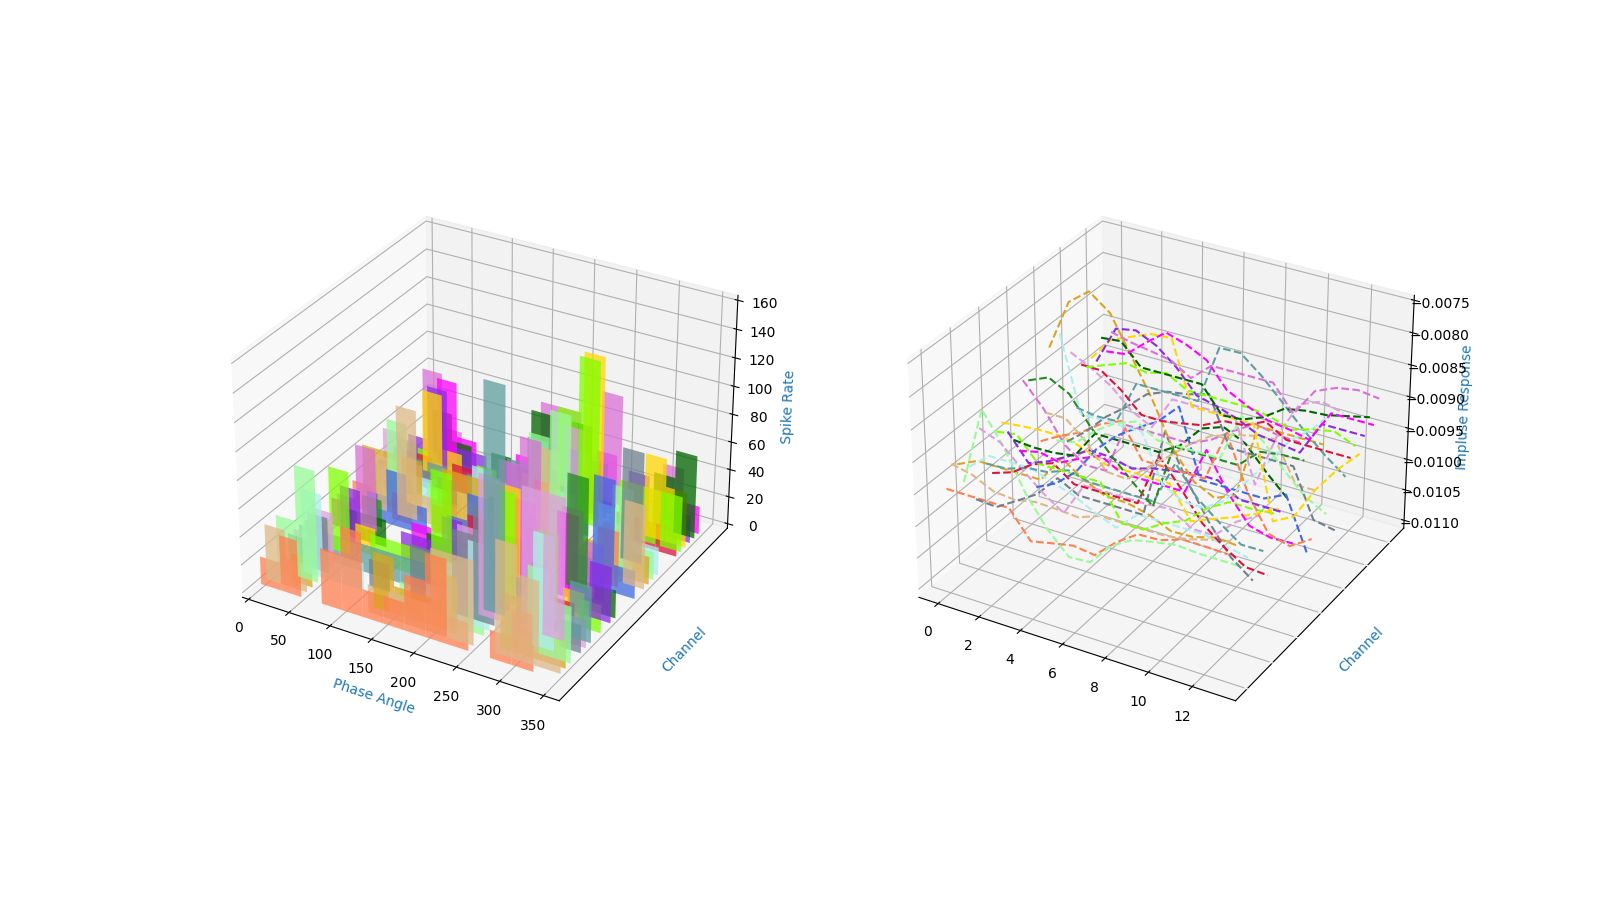

In [37]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
impulse_bins = padded_channel_response[0].shape[0]
x_values2= np.arange(0,impulse_bins,1) 
x_values1= np.arange(0,(x_values2[-1]+1)*resolution,1)*350/bins
colors = ['coral', 'burlywood','goldenrod','palegreen','paleturquoise','slategray','plum','cadetblue','crimson','chartreuse','gold',
'blueviolet','darkgreen','fuchsia','orchid', 'forestgreen','royalblue']
channel_range = np.arange(0,32,1)
# channel_range = [0, 9, 16]
# channel_range = np.arange(0,9,1)
for i in channel_range:
    color_index = i % len(colors)
    peak_incidence = math.floor(np.argmax(rates_by_phase[:,i])/resolution)
    rolled_channel = np.roll(padded_channel_response[i],peak_incidence)
    # print(x_values2.shape)
    # print(rolled_channel.shape)
    # print(channel_range.shape)

    ax2.plot(x_values2,rolled_channel, zs=channel_range[i], linestyle='--',zdir='y',color=colors[color_index])

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(x_values1, rates_by_phase[:,i], zs=channel_range[i], width=x_values1[1]-x_values1[0], align = 'edge', zdir='y', color=colors[color_index], alpha=0.75)

ax.set_xlabel("Phase Angle", color="C0")
ax.set_zlabel("Spike Rate", color="C0")
ax.set_ylabel("Channel", color="C0")
# ax.tick_params(axis='x', colors="C0")
# ax.tick_params(axis='y', colors="C0")
# ax2.xaxis.tick_top()
# ax2.yaxis.tick_right()
ax2.set_zlabel("Impluse Response", color="C0")      
ax2.set_ylabel("Channel", color="C0")

# ax2.xaxis.set_label_position('top') 
# ax2.yaxis.set_label_position('right') 
# ax2.tick_params(axis='x', colors="white")
ax.set_yticks([])

# ax.tick_params(axis='y', colors="white")
ax2.tick_params(axis='y', colors="white")

ax.set_xlim([0,360])
# ax.set_zlim([0,rates_by_phase.max()])
# On the y axis let's only label the discrete values that we have data for.
# ax.set_yticklabels(channel_range)
# fig.subplots_adjust(left=0,right=0.5,bottom=0,top=1)
# plt.subplots_adjust(wspace=1, hspace=1)
# if legend == True:
#     ax.legend(loc='lower right')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
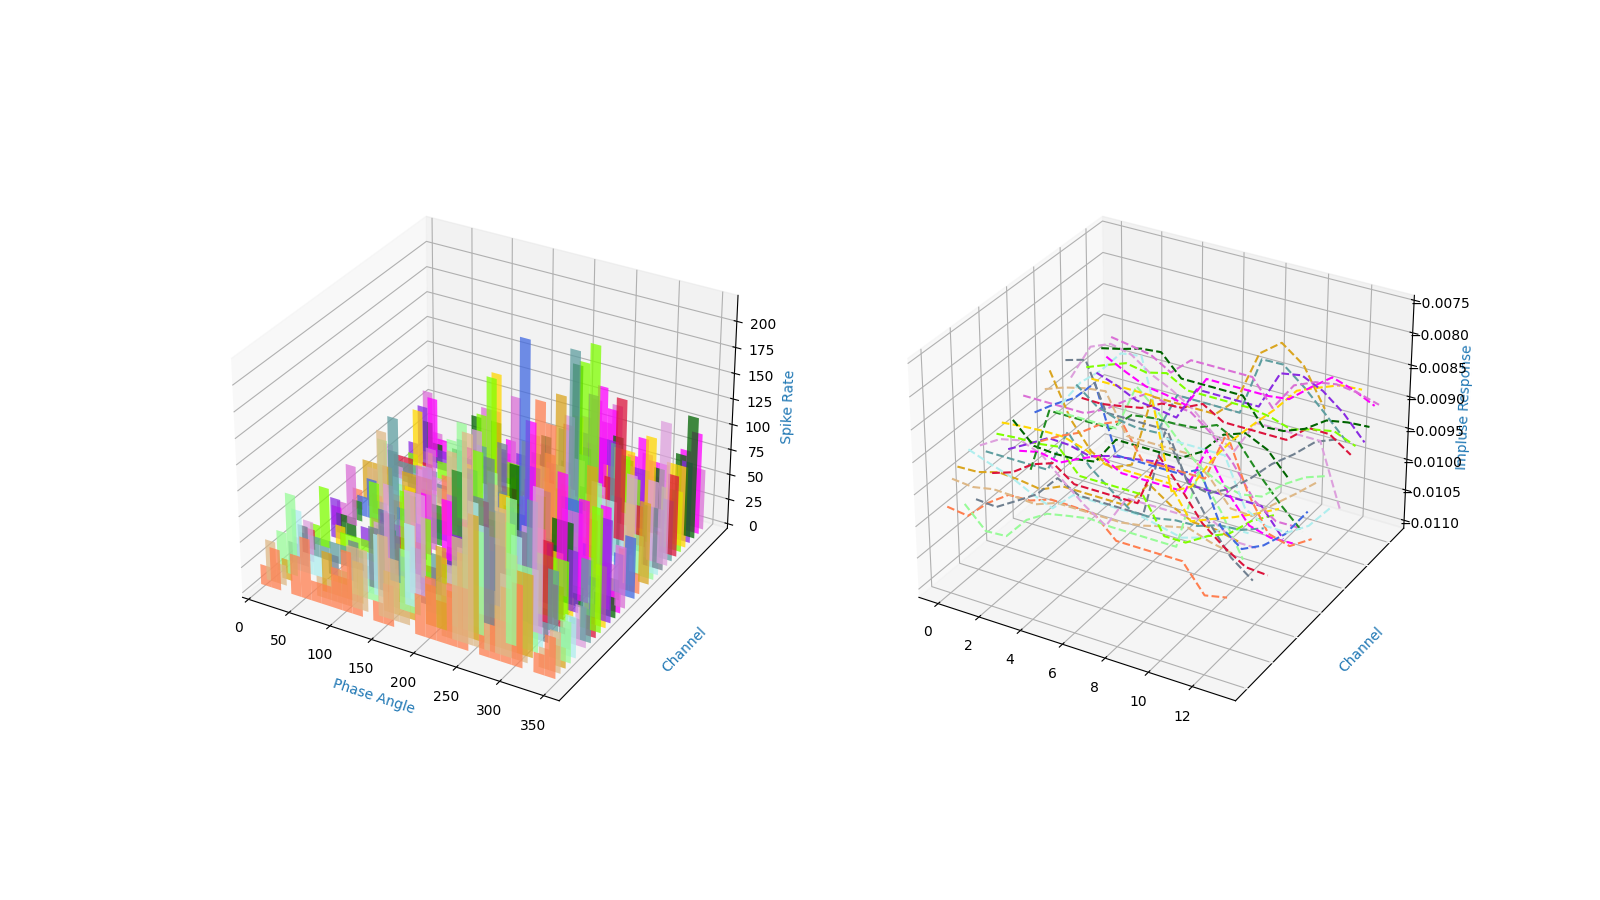

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
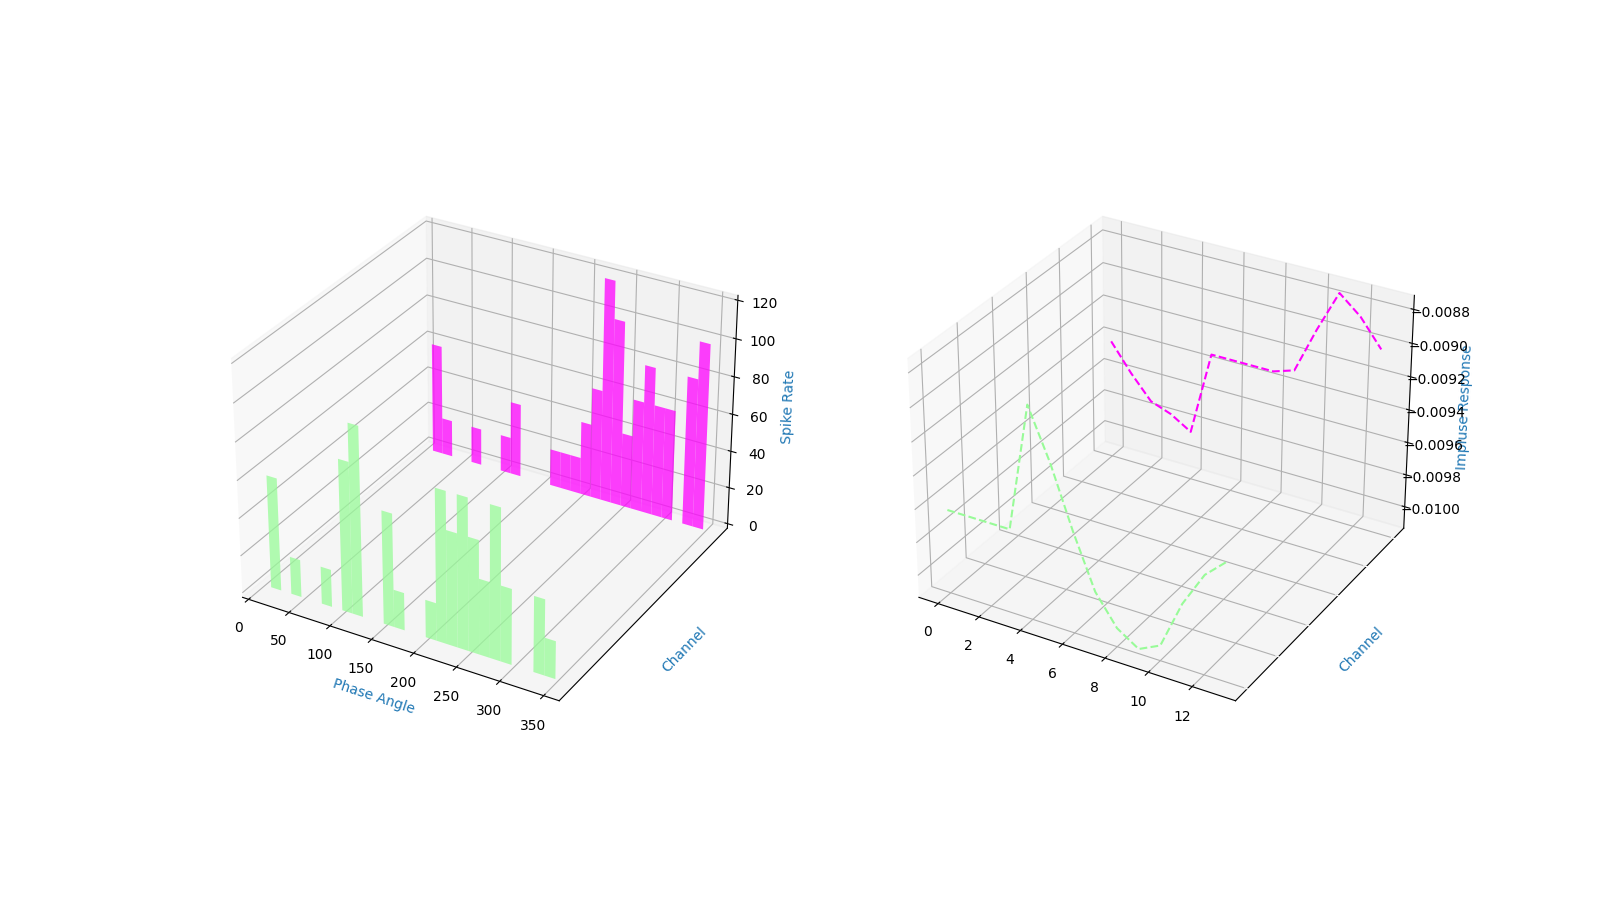

In [49]:
full_phase_list = mep919phase_list
rates_array = mep919full_rates
AOI = 3
H_mat = mep919H_cos
resolution = 2
ratexresponsemap(full_phase_list, rates_array, AOI, H_mat, resolution, view = '3D')
ratexresponsemap(full_phase_list, rates_array, AOI, H_mat, resolution, channel_range = [20, 30], view = '3D')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
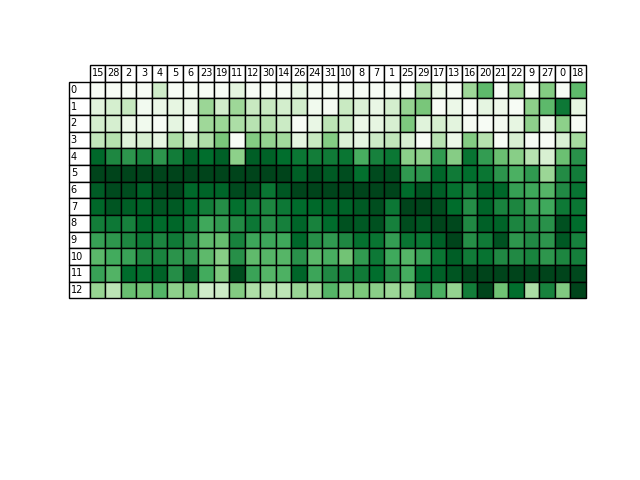

In [47]:
mep919_session.get_gait_indices()
mep919_session.divide_into_gaits()
temp = mep919_session.neuron_tuning()
plot_raster(temp)

In [44]:
print(tmpp)

None


/home/grant/anaconda3/envs/rat-fes/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
/home/grant/anaconda3/envs/rat-fes/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/grant/anaconda3/envs/rat-fes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
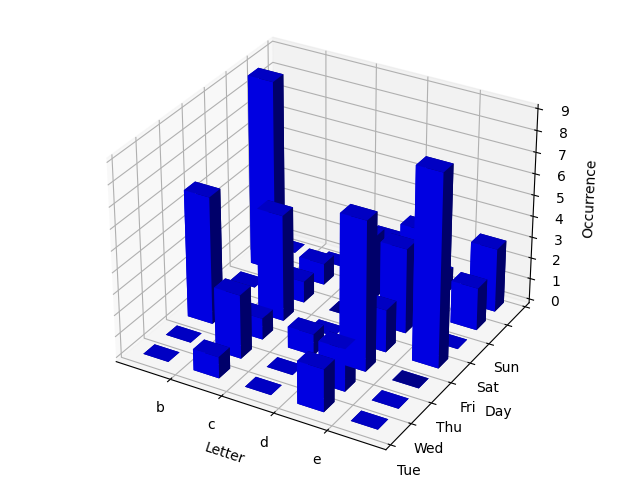

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

#from IPython.Shell import IPShellEmbed
#sh = IPShellEmbed()

data = np.array([
[0,1,0,2,0],
[0,3,0,2,0],
[6,1,1,7,0],
[0,5,0,2,9],
[0,1,0,4,0],
[9,1,3,4,2],
[0,0,2,1,3],
])

column_names = ['a','b','c','d','e']
row_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

fig = plt.figure()
ax = Axes3D(fig)

lx= len(data[0])            # Work out matrix dimensions
ly= len(data[:,0])
xpos = np.arange(0,lx,1)    # Set up a mesh of positions
ypos = np.arange(0,ly,1)
xpos, ypos = np.meshgrid(xpos+0.25, ypos+0.25)

xpos = xpos.flatten()   # Convert positions to 1D array
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color='b')

#sh()
ax.w_xaxis.set_ticklabels(column_names)
ax.w_yaxis.set_ticklabels(row_names)
ax.set_xlabel('Letter')
ax.set_ylabel('Day')
ax.set_zlabel('Occurrence')

plt.show()

In [ ]:
print(np.arange(0,32,1))